In [10]:
import torch.nn as nn
import torch
from copy import deepcopy
import os
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, sampler
import torchvision.transforms as transforms
import abc
import logging
import nibabel as nib
from pathlib import Path
from torch.utils.data import Dataset, sampler
import torchvision.transforms as transforms
import numpy as np
import torch
from time import time
import shutil
from sklearn.metrics import roc_auc_score
import torchio as tio
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict
import numpy as np
from os import path

In [11]:
%matplotlib inline

## Подготовим датасет и визуализируем примеры

In [3]:
FILENAME_TYPE = {'full': '_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w',
                 'cropped':'_acq-Sg3DT1200SlIso_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz',
#                 'cropped': '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w',
                 'skull_stripped': '_space-Ixi549Space_desc-skullstripped_T1w',
                 'gm_maps': '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability',
                 'shepplogan': '_phantom-SheppLogan'}

In [5]:
image_dir='/home/datasets/@Megatron/project_Alexeevskaya_preproc/clinica/CAPS/subjects'

In [6]:
image_paths =[]
not_existed_brain =[]

In [7]:
result_dict =defaultdict(list)

In [8]:
for pack in Path(image_dir).iterdir():
    if pack.is_dir():
        for inner_pack in Path(pack).iterdir():
            if inner_pack.is_dir():
                image_path = path.join(image_dir, pack.name, inner_pack.name,
                                   't1_linear',
                                   pack.name + '_' + inner_pack.name
                                   + FILENAME_TYPE['cropped'])
                if os.path.exists(image_path):
                    result_dict["participant_id"].append(pack.name)
                    result_dict["session_id"].append(inner_pack.name)

In [9]:
not_existed_brain

[]

In [10]:
test_df =pd.DataFrame.from_dict(result_dict)

In [11]:
test_df["diagnosis"] ='MCI'
test_df["cohort"] ='single'

In [12]:
test_df.shape

(130, 4)

In [13]:
test_df

,participant_id,session_id,diagnosis,cohort
0,sub-200421110741,ses-M00,MCI,single
1,sub-150621114958,ses-M00,MCI,single
2,sub-230421112224,ses-M00,MCI,single
3,sub-010621134043,ses-M00,MCI,single
4,sub-210421122822,ses-M00,MCI,single
...,...,...,...,...
125,sub-220321130157,ses-M00,MCI,single
126,sub-230421121723,ses-M00,MCI,single
127,sub-250521085545,ses-M00,MCI,single
128,sub-090621124036,ses-M00,MCI,single


In [14]:
image_path='/home/datasets/@Megatron/project_Alexeevskaya_preproc/clinica/CAPS/subjects/sub-010221105323/ses-M00/t1_linear/t1_liner/'

In [15]:
image_path='/home/datasets/@Megatron/project_Alexeevskaya_preproc/clinica/CAPS/subjects/sub-010221105323/ses-M00/t1_linear/sub-010221105323_ses-M00_acq-Sg3DT1200SlIso_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz'

In [16]:
img =nib.load(image_path)

In [17]:
img=img.get_fdata()

In [18]:
img.shape

(169, 208, 179)

In [19]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices),figsize=(25,25))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Center slices for EPI image')

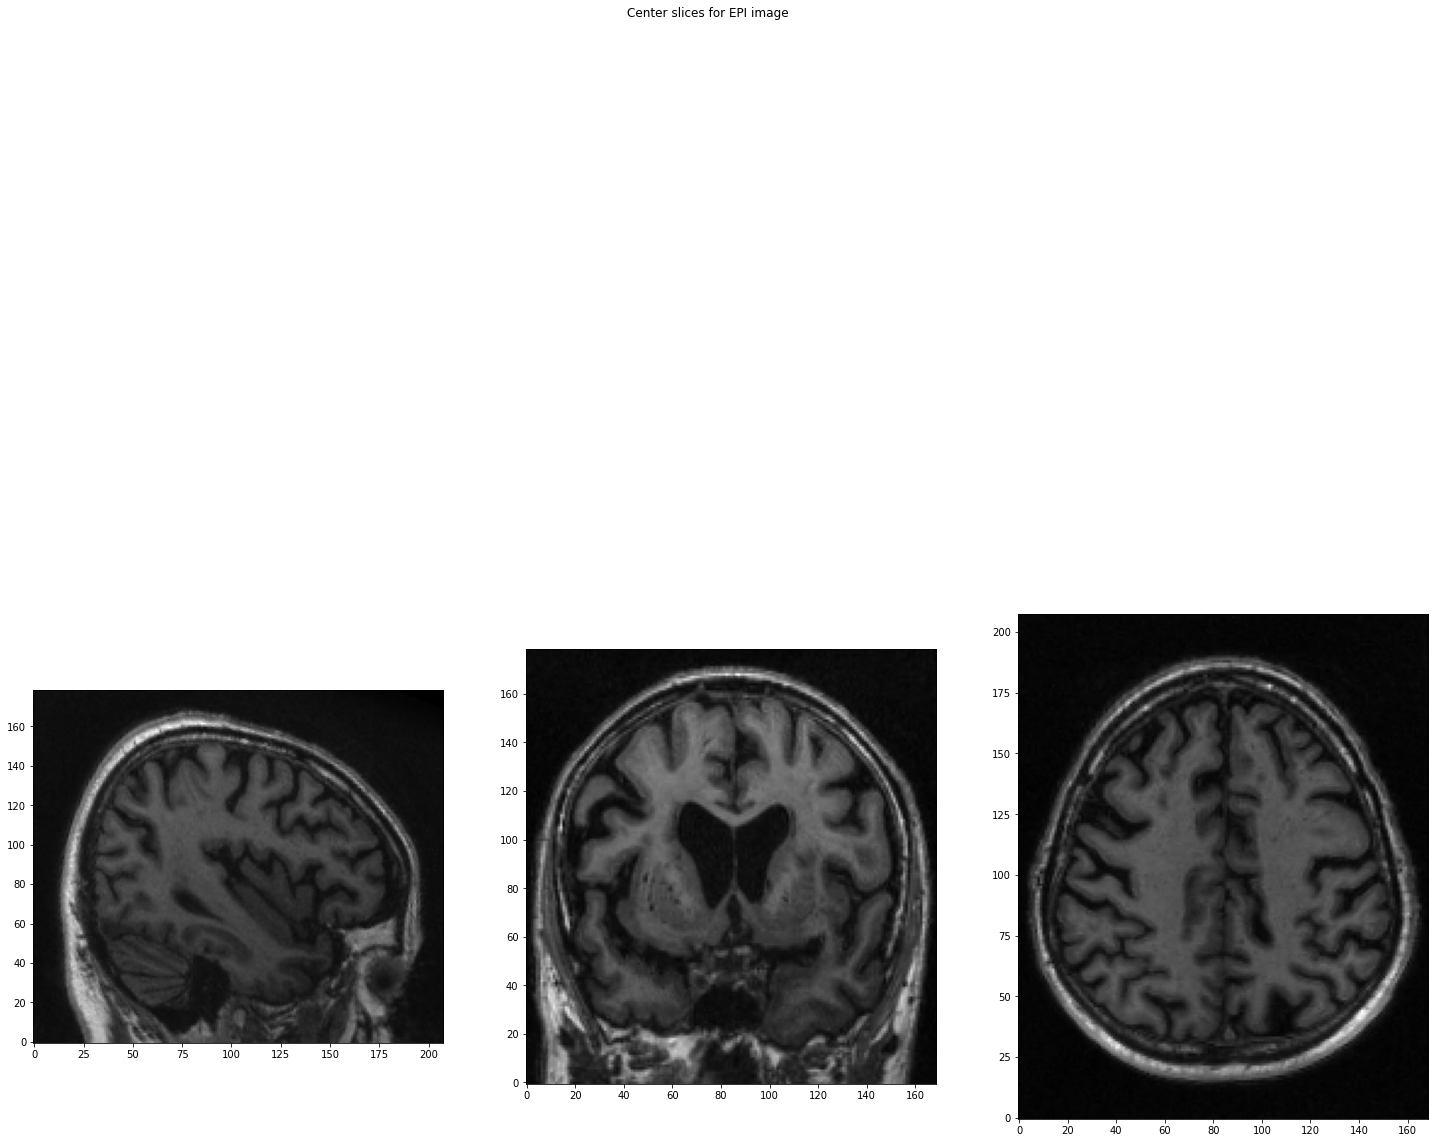

In [20]:
slice_0 = img[128, :, :]
slice_1 = img[:, 128, :]
slice_2 = img[:, :, 128]
show_slices([slice_0, slice_1, slice_2])

plt.suptitle("Center slices for EPI image")  

##  Проведем эксперимент с предсказанием диагнозов по обученной модели

In [21]:
class MRIDataset(Dataset):
    """Abstract class for all derived MRIDatasets."""

    def __init__(self, caps_directory, data_file,
                 preprocessing, transformations, labels,
                 augmentation_transformations=None, multi_cohort=False):
        self.caps_dict = self.create_caps_dict(caps_directory, multi_cohort)
        self.transformations = transformations
        self.augmentation_transformations = augmentation_transformations
        self.eval_mode = False
        self.labels = labels
        self.diagnosis_code = {
            'CN': 0,
            'BV': 1,
            'AD': 1,
            'sMCI': 0,
            'pMCI': 1,
            'MCI': 1,
            'unlabeled': -1}
        self.preprocessing = preprocessing

        if not hasattr(self, 'elem_index'):
            raise ValueError(
                "Child class of MRIDataset must set elem_index attribute.")
        if not hasattr(self, 'mode'):
            raise ValueError(
                "Child class of MRIDataset must set mode attribute.")

        # Check the format of the tsv file here
        if isinstance(data_file, str):
            self.df = pd.read_csv(data_file, sep='\t')
        elif isinstance(data_file, pd.DataFrame):
            self.df = data_file
        else:
            raise Exception('The argument data_file is not of correct type.')

        if not multi_cohort:
            self.df["cohort"] = "single"

        mandatory_col = {"participant_id", "session_id"}
        if self.labels:
            mandatory_col.add("diagnosis")
        if multi_cohort:
            mandatory_col.add("cohort")
        if self.elem_index == "mixed":
            mandatory_col.add("%s_id" % self.mode)

        if not mandatory_col.issubset(set(self.df.columns.values)):
            raise Exception("the data file is not in the correct format."
                            "Columns should include %s" % mandatory_col)

        unique_diagnoses = set(self.df.diagnosis)
        unique_codes = set()
        for diagnosis in unique_diagnoses:
            unique_codes.add(self.diagnosis_code[diagnosis])
        # if len(unique_codes) == 
        #     warnings.warn("The diagnoses found in the DataFrame %s only corresponds to one class %s. "
        #                   "If you want to run a binary classification please change the labels involved."
        #                   % (unique_diagnoses, unique_codes))

        self.elem_per_image = self.num_elem_per_image()
        self.size = self[0]['image'].size()

    def __len__(self):
        return len(self.df) * self.elem_per_image

    @staticmethod
    def create_caps_dict(caps_directory, multi_cohort):
        caps_dict = {'single': caps_directory}
        return caps_dict

    def _get_path(self, participant, session, cohort, mode="image"):

        if cohort not in self.caps_dict.keys():
            raise ValueError('Cohort names in labels and CAPS definitions do not match.')

        image_path = path.join(self.caps_dict[cohort], 'subjects', participant, session,
                                   't1_linear',
                                   participant + '_' + session
                                   + FILENAME_TYPE['cropped'])

        return image_path

    def _get_meta_data(self, idx):
        image_idx = idx // self.elem_per_image
        participant = self.df.loc[image_idx, 'participant_id']
        session = self.df.loc[image_idx, 'session_id']
        cohort = self.df.loc[image_idx, 'cohort']

        if self.elem_index is None:
            elem_idx = idx % self.elem_per_image
        elif self.elem_index == "mixed":
            elem_idx = self.df.loc[image_idx, '%s_id' % self.mode]
        else:
            elem_idx = self.elem_index

        if self.labels:
            diagnosis = self.df.loc[image_idx, 'diagnosis']
            label = self.diagnosis_code[diagnosis]
        else:
            label = self.diagnosis_code['unlabeled']

        return participant, session, cohort, elem_idx, label

    def _get_full_image(self):

        participant_id = self.df.loc[0, 'participant_id']
        session_id = self.df.loc[0, 'session_id']
        cohort = self.df.loc[0, 'cohort']

        try:
            image_path = self._get_path(participant_id, session_id, cohort, mode="image")
            image = torch.load(image_path)
        except FileNotFoundError:
            image_path = get_nii_path(
                self.caps_dict,
                participant_id,
                session_id,
                cohort=cohort,
                preprocessing=self.preprocessing)
            image_nii = nib.load(image_path)
            image_np = image_nii.get_fdata()
            image = ToTensor()(image_np)

        return image

    @abc.abstractmethod
    def __getitem__(self, idx):
        pass

    @abc.abstractmethod
    def num_elem_per_image(self):
        pass

    def eval(self):
        self.eval_mode = True
        return self

    def train(self):
        self.eval_mode = False
        return self

In [22]:
class MRIDatasetImage(MRIDataset):
    """Dataset of MRI organized in a CAPS folder."""

    def __init__(self, caps_directory, data_df,
                 preprocessing='t1-linear', train_transformations=None,
                 labels=True, all_transformations=None, multi_cohort=False):
        """
        Args:
            caps_directory (string): Directory of all the images.
            data_file (string or DataFrame): Path to the tsv file or DataFrame containing the subject/session list.
            preprocessing (string): Defines the path to the data in CAPS.
            train_transformations (callable, optional): Optional transform to be applied only on training mode.
            labels (bool): If True the diagnosis will be extracted from the given DataFrame.
            all_transformations (callable, options): Optional transform to be applied during training and evaluation.
            multi_cohort (bool): If True caps_directory is the path to a TSV file linking cohort names and paths.
        """
        self.elem_index = None
        self.mode = "image"
        super().__init__(caps_directory, data_df, preprocessing,
                         augmentation_transformations=train_transformations, labels=labels,
                         transformations=all_transformations, multi_cohort=multi_cohort)

    def __getitem__(self, idx):
        participant, session, cohort, _, label = self._get_meta_data(idx)

        image_path = self._get_path(participant, session, cohort, "image")
        #image = torch.load(image_path)
        
        image_nii = nib.load(image_path)
        image_np = image_nii.get_fdata()
        image = ToTensor()(image_np)

        if self.transformations:
            image = self.transformations(image)

        if self.augmentation_transformations and not self.eval_mode:
            image = self.augmentation_transformations(image)

        sample = {'image': image, 'label': label, 'participant_id': participant, 'session_id': session,
                  'image_path': image_path}

        return sample

    def num_elem_per_image(self):
        return 1


In [23]:
def test(model, dataloader, use_cuda, criterion, mode="image", use_labels=True):
    """
    Computes the predictions and evaluation metrics.
    Args:
        model: (Module) CNN to be tested.
        dataloader: (DataLoader) wrapper of a dataset.
        use_cuda: (bool) if True a gpu is used.
        criterion: (loss) function to calculate the loss.
        mode: (str) input used by the network. Chosen from ['image', 'patch', 'roi', 'slice'].
        use_labels (bool): If True the true_label will be written in output DataFrame and metrics dict will be created.
    Returns
        (DataFrame) results of each input.
        (dict) ensemble of metrics + total loss on mode level.
    """
    model.eval()
    dataloader.dataset.eval()

    columns = ["participant_id", "session_id", "true_label", "predicted_label", "probability"]

    softmax = torch.nn.Softmax(dim=1)
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0
    total_kl_loss = 0
    total_time = 0
    tend = time()
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            t0 = time()
            total_time = total_time + t0 - tend
            if use_cuda:
                inputs, labels = data['image'].cuda(), data['label'].cuda()
            else:
                inputs, labels = data['image'], data['label']

            outputs = model(inputs)
            if use_labels:
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            # Generate detailed DataFrame
            for idx, sub in enumerate(data['participant_id']):
                if mode == "image":
                    normalized_output = softmax(outputs)
                    row = [[sub, data['session_id'][idx], labels[idx].item(), predicted[idx].item(), normalized_output[idx][predicted[idx].item()].item()]]
                else:
                    normalized_output = softmax(outputs)
                    row = [[sub, data['session_id'][idx], data['%s_id' % mode][idx].item(),
                            labels[idx].item(), predicted[idx].item(),
                            normalized_output[idx, 0].item(), normalized_output[idx, 1].item()]]

                row_df = pd.DataFrame(row, columns=columns)
                results_df = pd.concat([results_df, row_df])

            del inputs, outputs, labels
            tend = time()
        results_df.reset_index(inplace=True, drop=True)

    if not use_labels:
        results_df = results_df.drop("true_label", axis=1)
        metrics_dict = None
    else:
        metrics_dict = evaluate_prediction(results_df.true_label.values.astype(int),
                                           results_df.predicted_label.values.astype(int))
        metrics_dict['total_loss'] = total_loss
        metrics_dict['total_kl_loss'] = total_kl_loss
    torch.cuda.empty_cache()

    return results_df, metrics_dict


def evaluate_prediction(y, y_pred):
    """
    Evaluates different metrics based on the list of true labels and predicted labels.
    Args:
        y: (list) true labels
        y_pred: (list) corresponding predictions
    Returns:
        (dict) ensemble of metrics
    """

    true_positive = np.sum((y_pred == 1) & (y == 1))
    true_negative = np.sum((y_pred == 0) & (y == 0))
    false_positive = np.sum((y_pred == 1) & (y == 0))
    false_negative = np.sum((y_pred == 0) & (y == 1))

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)*100

    if (true_positive + false_negative) != 0:
        sensitivity = true_positive / (true_positive + false_negative)*100
    else:
        sensitivity = 0.0

    if (false_positive + true_negative) != 0:
        specificity = true_negative / (false_positive + true_negative)*100
    else:
        specificity = 0.0

    if (true_positive + false_positive) != 0:
        ppv = true_positive / (true_positive + false_positive)*100
    else:
        ppv = 0.0

    if (true_negative + false_negative) != 0:
        npv = true_negative / (true_negative + false_negative)*100
    else:
        npv = 0.0

#     roc_auc_sk = roc_auc_score(y, y_pred)* 100
    balanced_accuracy = ((sensitivity + specificity) / 2)

    results = {'accuracy': round(accuracy,3),
               'balanced_accuracy': round(balanced_accuracy,3),
               'sensitivity': round(sensitivity,3),
               'specificity': round(specificity,3),
               'ppv': round(ppv,3),
               'npv': round(npv,3),
#                'roc_auc_sk': round(roc_auc_sk, 3)
               }

    return results

def save_checkpoint(state, accuracy_is_best, loss_is_best, checkpoint_dir, filename='checkpoint.pth.tar',
                    best_accuracy='best_balanced_accuracy', best_loss='best_loss'):

    os.makedirs(checkpoint_dir, exist_ok=True)

    torch.save(state, os.path.join(checkpoint_dir, filename))
    if accuracy_is_best:
        best_accuracy_path = os.path.join(checkpoint_dir, best_accuracy)
        if not os.path.exists(best_accuracy_path):
            os.makedirs(best_accuracy_path)
        shutil.copyfile(os.path.join(checkpoint_dir, filename),  os.path.join(best_accuracy_path, 'model_best.pth.tar'))

    if loss_is_best:
        best_loss_path = os.path.join(checkpoint_dir, best_loss)
        os.makedirs(best_loss_path, exist_ok=True)
        shutil.copyfile(os.path.join(checkpoint_dir, filename), os.path.join(best_loss_path, 'model_best.pth.tar'))


In [24]:
def load_model(model, checkpoint_dir, gpu, filename='model_best.pth.tar'):
    """
    Load the weights written in checkpoint_dir in the model object.
    :param model: (Module) CNN in which the weights will be loaded.
    :param checkpoint_dir: (str) path to the folder containing the parameters to loaded.
    :param gpu: (bool) if True a gpu is used.
    :param filename: (str) Name of the file containing the parameters to loaded.
    :return: (Module) the update model.
    """
    best_model = deepcopy(model)
    param_dict = torch.load(os.path.join(checkpoint_dir, filename), map_location="cpu")
    best_model.load_state_dict(param_dict['model'])

    if gpu:
        best_model = best_model.cuda()

    return best_model, param_dict['epoch']

In [25]:
def soft_voting(performance_df, validation_df, mode, selection_threshold=None, use_labels=True):
    """
    Computes soft voting based on the probabilities in performance_df. Weights are computed based on the accuracies
    of validation_df.
    ref: S. Raschka. Python Machine Learning., 2015
    Args:
        performance_df: (DataFrame) results on patch level of the set on which the combination is made.
        validation_df: (DataFrame) results on patch level of the set used to compute the weights.
        mode: (str) input used by the network. Chosen from ['patch', 'roi', 'slice'].
        selection_threshold: (float) if given, all patches for which the classification accuracy is below the
            threshold is removed.
    Returns:
        df_final (DataFrame) the results on the image level
        results (dict) the metrics on the image level
    """

    # Compute the sub-level accuracies on the validation set:
    validation_df["accurate_prediction"] = validation_df.apply(lambda x: check_prediction(x), axis=1)
    sub_level_accuracies = validation_df.groupby("%s_id" % mode)["accurate_prediction"].sum()
    if selection_threshold is not None:
        sub_level_accuracies[sub_level_accuracies < selection_threshold] = 0
    weight_series = sub_level_accuracies / sub_level_accuracies.sum()

    # Sort to allow weighted average computation
    performance_df.sort_values(['participant_id', 'session_id', '%s_id' % mode], inplace=True)
    weight_series.sort_index(inplace=True)

    # Soft majority vote
    if use_labels:
        columns = ['participant_id', 'session_id', 'true_label', 'predicted_label']
    else:
        columns = ['participant_id', 'session_id', 'predicted_label']
    df_final = pd.DataFrame(columns=columns)
    for (subject, session), subject_df in performance_df.groupby(['participant_id', 'session_id']):
        proba0 = np.average(subject_df["proba0"], weights=weight_series)
        proba1 = np.average(subject_df["proba1"], weights=weight_series)
        proba_list = [proba0, proba1]
        y_hat = proba_list.index(max(proba_list))

        if use_labels:
            y = subject_df["true_label"].unique().item()
            row = [[subject, session, y, y_hat]]
        else:
            row = [[subject, session, y_hat]]
        row_df = pd.DataFrame(row, columns=columns)
        df_final = df_final.append(row_df)

    if use_labels:
        results = evaluate_prediction(df_final.true_label.values.astype(int),
                                      df_final.predicted_label.values.astype(int))
    else:
        results = None

    return df_final, results

In [26]:
def soft_voting_to_tsvs(output_dir, fold, selection, mode, dataset='test', num_cnn=None,
                        selection_threshold=None, logger=None, use_labels=True):
    """
    Writes soft voting results in tsv files.
    Args:
        output_dir: (str) path to the output directory.
        fold: (int) Fold number of the cross-validation.
        selection: (str) criterion on which the model is selected (either best_loss or best_acc)
        mode: (str) input used by the network. Chosen from ['patch', 'roi', 'slice'].
        dataset: (str) name of the dataset for which the soft-voting is performed. If different from training or
            validation, the weights of soft voting will be computed on validation accuracies.
        num_cnn: (int) if given load the patch level results of a multi-CNN framework.
        selection_threshold: (float) all patches for which the classification accuracy is below the
            threshold is removed.
        logger: (logging object) writer to stdout and stderr
        use_labels: (bool) If True the labels are added to the final tsv
    """
    if logger is None:
        logger = logging

    # Choose which dataset is used to compute the weights of soft voting.
    if dataset in ['train', 'validation']:
        validation_dataset = dataset
    else:
        validation_dataset = 'validation'
    test_df = retrieve_sub_level_results(output_dir, fold, selection, mode, dataset, num_cnn)
    validation_df = retrieve_sub_level_results(output_dir, fold, selection, mode, validation_dataset, num_cnn)

    performance_path = os.path.join(output_dir, 'fold-%i' % fold, 'cnn_classification', selection)
    os.makedirs(performance_path, exist_ok=True)

    df_final, metrics = soft_voting(test_df, validation_df, mode, selection_threshold=selection_threshold,
                                    use_labels=use_labels)

    df_final.to_csv(os.path.join(os.path.join(performance_path, '%s_image_level_prediction.tsv' % dataset)),
                    index=False, sep='\t')
    if use_labels:
        pd.DataFrame(metrics, index=[0]).to_csv(os.path.join(performance_path, '%s_image_level_metrics.tsv' % dataset),
                                                index=False, sep='\t')
        logger.info("image level %s balanced accuracy is %f for model selected on %s"
                    % (dataset, metrics["balanced_accuracy"], selection))

def retrieve_sub_level_results(output_dir, fold, selection, mode, dataset, num_cnn):
    """Retrieve performance_df for single or multi-CNN framework.
    If the results of the multi-CNN were not concatenated it will be done here."""
    result_tsv = os.path.join(output_dir, 'fold-%i' % fold, 'cnn_classification', selection,
                              '%s_%s_level_prediction.tsv' % (dataset, mode))
    if os.path.exists(result_tsv):
        performance_df = pd.read_csv(result_tsv, sep='\t')

    else:
        concat_multi_cnn_results(output_dir, fold, selection, mode, dataset, num_cnn)
        performance_df = pd.read_csv(result_tsv, sep='\t')

    return performance_df


In [27]:
def test_single_cnn(model, output_dir, data_loader, subset_name, split, criterion, mode, logger, selection_threshold,
                    gpu=False):
    for selection in ["best_balanced_accuracy", "best_loss"]:
        # load the best trained model during the training
        model, best_epoch = load_model(model, os.path.join(output_dir, 'fold-%i' % split, 'models', selection),
                                       gpu=gpu, filename='model_best.pth.tar')

        results_df, metrics = test(model, data_loader, gpu, criterion, mode)
        print(results_df)
        print("Metrics:")
        print(metrics)
        logger.info("%s level %s balanced accuracy is %f for model selected on %s"
                    % (mode, subset_name, metrics["balanced_accuracy"], selection))

        mode_level_to_tsvs(output_dir, results_df, metrics, split, selection, mode, dataset=subset_name)
        print('presoft_voting')
        # Soft voting
        if data_loader.dataset.elem_per_image > 1:
            print('soft_voting')
            soft_voting_to_tsvs(output_dir, split, logger=logger, selection=selection, mode=mode,
                                dataset=subset_name, selection_threshold=selection_threshold)
            

In [28]:

"""The project is inspired by the clinica /clinicadl library, the code is taken from https://github.com/aramis-lab/AD-DL"""

import torch.nn as nn
import torch
from copy import deepcopy
import os

def load_model(model, checkpoint_dir, gpu, filename='model_best.pth.tar'):
    """
    Load the weights written in checkpoint_dir in the model object.
    :param model: (Module) CNN in which the weights will be loaded.
    :param checkpoint_dir: (str) path to the folder containing the parameters to loaded.
    :param gpu: (bool) if True a gpu is used.
    :param filename: (str) Name of the file containing the parameters to loaded.
    :return: (Module) the update model.
    """
    best_model = deepcopy(model)
    param_dict = torch.load(os.path.join(checkpoint_dir, filename), map_location="cpu")
    best_model.load_state_dict(param_dict['model'])

    if gpu:
        best_model = best_model.cuda()

    return best_model, param_dict['epoch']

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size

    def forward(self, input):
        return input.view(*self.size)

class Conv5_FC3(nn.Module):
    """
    Classifier for a binary classification task
    Image level architecture used on Minimal preprocessing
    """
    def __init__(self, dropout=0.5):
        super(Conv5_FC3, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

        )

        self.classifier = nn.Sequential(
            Flatten(),
            nn.Dropout(p=dropout),

            nn.Linear(128 * 6 * 7 * 6, 1300),
            nn.ReLU(),

            nn.Linear(1300, 50),
            nn.ReLU(),

            nn.Linear(50, 2)

        )
        self.gradients = None
        self.flattened_shape = [-1, 128, 6, 7, 6]

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)
        x = self.classifier(x)

        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

class PadMaxPool3d(nn.Module):
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(
            kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride -
                  f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output



class CropMaxUnpool3d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool3d, self).__init__()
        self.unpool = nn.MaxUnpool3d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[4]
            y1 = padding[2]
            z1 = padding[0]
            output = output[:, :, x1::, y1::, z1::]

        return output


class CropMaxUnpool2d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool2d, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[2]
            y1 = padding[0]
            output = output[:, :, x1::, y1::]

        return output

class PadMaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool2d(
            kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad2d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride -
                  f_maps.size(i + 2) % self.stride for i in range(2)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[1], 0, coords[0], 0)
            else:
                return output


class AutoEncoder(nn.Module):

    def __init__(self, model=None):
        """
        Construct an autoencoder from a given CNN. The encoder part corresponds to the convolutional part of the CNN.
        :param model: (Module) a CNN. The convolutional part must be comprised in a 'features' class variable.
        """
        from copy import deepcopy
        super(AutoEncoder, self).__init__()

        self.level = 0

        if model is not None:
            self.encoder = deepcopy(model.features)
            self.decoder = self.construct_inv_layers(model)

            for i, layer in enumerate(self.encoder):
                if isinstance(layer, PadMaxPool3d):
                    self.encoder[i].set_new_return()
                elif isinstance(layer, nn.MaxPool3d):
                    self.encoder[i].return_indices = True
        else:
            self.encoder = nn.Sequential()
            self.decoder = nn.Sequential()

    def __len__(self):
        return len(self.encoder)

    def forward(self, x):

        indices_list = []
        pad_list = []
        for layer in self.encoder:
            if isinstance(layer, PadMaxPool3d):
                x, indices, pad = layer(x)
                indices_list.append(indices)
                pad_list.append(pad)
            elif isinstance(layer, nn.MaxPool3d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)

        for layer in self.decoder:
            if isinstance(layer, CropMaxUnpool3d):
                x = layer(x, indices_list.pop(), pad_list.pop())
            elif isinstance(layer, nn.MaxUnpool3d):
                x = layer(x, indices_list.pop())
            else:
                x = layer(x)

        return x

    def construct_inv_layers(self, model):
        """
        Implements the decoder part from the CNN. The decoder part is the symmetrical list of the encoder
        in which some layers are replaced by their transpose counterpart.
        ConvTranspose and ReLU layers are inverted in the end.
        :param model: (Module) a CNN. The convolutional part must be comprised in a 'features' class variable.
        :return: (Module) decoder part of the Autoencoder
        """
        inv_layers = []
        for i, layer in enumerate(self.encoder):
            if isinstance(layer, nn.Conv3d):
                inv_layers.append(nn.ConvTranspose3d(layer.out_channels, layer.in_channels, layer.kernel_size,
                                                     stride=layer.stride, padding=layer.padding))
                self.level += 1
            elif isinstance(layer, PadMaxPool3d):
                inv_layers.append(CropMaxUnpool3d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, PadMaxPool2d):
                inv_layers.append(CropMaxUnpool2d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, nn.Linear):
                inv_layers.append(nn.Linear(layer.out_features, layer.in_features))
            elif isinstance(layer, Flatten):
                inv_layers.append(Reshape(model.flattened_shape))
            elif isinstance(layer, nn.LeakyReLU):
                inv_layers.append(nn.LeakyReLU(negative_slope=1 / layer.negative_slope))
            else:
                inv_layers.append(deepcopy(layer))
        inv_layers = self.replace_relu(inv_layers)
        inv_layers.reverse()
        return nn.Sequential(*inv_layers)

    @staticmethod
    def replace_relu(inv_layers):
        """
        Invert convolutional and ReLU layers (give empirical better results)
        :param inv_layers: (list) list of the layers of decoder part of the Auto-Encoder
        :return: (list) the layers with the inversion
        """
        idx_relu, idx_conv = -1, -1
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.ConvTranspose3d):
                idx_conv = idx
            elif isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
                idx_relu = idx

            if idx_conv != -1 and idx_relu != -1:
                inv_layers[idx_relu], inv_layers[idx_conv] = inv_layers[idx_conv], inv_layers[idx_relu]
                idx_conv, idx_relu = -1, -1

        # Check if number of features of batch normalization layers is still correct
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.BatchNorm3d):
                conv = inv_layers[idx + 1]
                inv_layers[idx] = nn.BatchNorm3d(conv.out_channels)

        return inv_layers

def transfer_autoencoder_weights(model, source_path, split):
    """
    Set the weights of the model according to the autoencoder at source path.
    The encoder part of the autoencoder must exactly correspond to the convolutional part of the model.
    :param model: (Module) the model which must be initialized
    :param source_path: (str) path to the source task experiment
    :param split: (int) split number to load
    :return: (str) path to the written weights ready to be loaded
    """

    if not isinstance(model, AutoEncoder):
        decoder = AutoEncoder(model)
    else:
        decoder = model

    model_path = os.path.join(source_path, 'fold-%i' % split, 'models', "best_loss", "model_best.pth.tar")
    source_dict = torch.load(model_path)

    initialize_other_autoencoder(decoder, source_dict)

    if not isinstance(model, AutoEncoder):
        model.features = deepcopy(decoder.encoder)
        for layer in model.features:
            if isinstance(layer, PadMaxPool3d):
                layer.set_new_return(False, False)

    return model


def transfer_cnn_weights(model, source_path, split, selection="best_balanced_accuracy", cnn_index=None):
    """
    Set the weights of the model according to the CNN at source path.
    :param model: (Module) the model which must be initialized
    :param source_path: (str) path to the source task experiment
    :param split: (int) split number to load
    :param selection: (str) chooses on which criterion the source model is selected (ex: best_loss, best_acc)
    :param cnn_index: (int) index of the CNN to be loaded (if transfer from a multi-CNN).
    :return: (str) path to the written weights ready to be loaded
    """

    if isinstance(model, AutoEncoder):
        raise ValueError('Transfer learning from CNN to autoencoder was not implemented.')

    model_path = os.path.join(source_path, "fold-%i" % split, "models", selection, "model_best.pth.tar")
    if cnn_index is not None and not os.path.exists(model_path):
        print("Transfer learning from multi-CNN, cnn-%i" % cnn_index)
        model_path = os.path.join(source_path, "fold_%i" % split, "models", "cnn-%i" % cnn_index,
                                  selection, "model_best.pth.tar")
    results = torch.load(model_path)
    model.load_state_dict(results['model'])

    return model

def initialize_other_autoencoder(decoder, source_dict):
    """
    Initialize an autoencoder with another one values even if they have different sizes.
    :param decoder: (Autoencoder) Autoencoder constructed from a CNN with the Autoencoder class.
    :param source_dict: (dict) The result dict produced by save_checkpoint.
    :return: (Autoencoder) initialized autoencoder
    """

    try:
        decoder.load_state_dict(source_dict['model'])
    except RuntimeError:
        print("The source and target autoencoders do not have the same size."
              "The transfer learning task may not work correctly for custom models.")

        parameters_dict = source_dict['model']
        difference = find_maximum_layer(decoder.state_dict()) - find_maximum_layer(parameters_dict)

        for key in parameters_dict.keys():
            section, number, spec = key.split('.')
            number = int(number)
            if section == 'encoder' and number < len(decoder.encoder):
                data = getattr(getattr(decoder, section)[number], spec).data
                assert data.shape == parameters_dict[key].shape
                getattr(getattr(decoder, section)[number], spec).data = parameters_dict[key]
            elif section == 'decoder':
                # Deeper target autoencoder
                if difference >= 0:
                    data = getattr(getattr(decoder, section)[number + difference], spec).data
                    assert data.shape == parameters_dict[key].shape
                    getattr(getattr(decoder, section)[number + difference], spec).data = parameters_dict[key]
                # More shallow target autoencoder
                elif difference < 0 and number < len(decoder.decoder):
                    data = getattr(getattr(decoder, section)[number], spec).data
                    new_key = '.'.join(['decoder', str(number + abs(difference)), spec])
                    assert data.shape == parameters_dict[new_key].shape
                    getattr(getattr(decoder, section)[number], spec).data = parameters_dict[new_key]

    return decoder

def find_maximum_layer(state_dict):
    max_layer = 0
    for key in state_dict.keys():
        _, num, _ = key.split(".")
        num = int(num)
        if num > max_layer:
            max_layer = num
    return max_layer


In [29]:


class RandomNoising(object):
    """Applies a random zoom to a tensor"""

    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, image):
        import random

        sigma = random.uniform(0, self.sigma)
        dist = torch.distributions.normal.Normal(0, sigma)
        return image + dist.sample(image.shape)


class RandomSmoothing(object):
    """Applies a random zoom to a tensor"""

    def __init__(self, sigma=1):
        self.sigma = sigma

    def __call__(self, image):
        import random
        from scipy.ndimage import gaussian_filter

        sigma = random.uniform(0, self.sigma)
        image = gaussian_filter(image, sigma)  # smoothing of data
        image = torch.from_numpy(image).float()
        return image


class RandomCropPad(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, image):
        dimensions = len(image.shape) - 1
        crop = np.random.randint(-self.length, self.length, dimensions)
        if dimensions == 2:
            output = torch.nn.functional.pad(image, (-crop[0], crop[0], -crop[1], crop[1]))
        elif dimensions == 3:
            output = torch.nn.functional.pad(image, (-crop[0], crop[0], -crop[1], crop[1], -crop[2], crop[2]))
        else:
            raise ValueError("RandomCropPad is only available for 2D or 3D data.")
        return output

class MinMaxNormalization(object):
    """Normalizes a tensor between 0 and 1"""

    def __call__(self, image):
        return (image - image.min()) / (image.max() - image.min())

class ToTensor(object):
    """Convert image type to Tensor and diagnosis to diagnosis code"""

    def __call__(self, image):
        np.nan_to_num(image, copy=False)
        image = image.astype(float)

        return torch.from_numpy(image[np.newaxis, :]).float()

In [30]:
# coding: utf8

"""The project is inspired by the clinica /clinicadl library, the code is taken from https://github.com/aramis-lab/AD-DL"""

import logging
import sys

LOG_LEVELS = [logging.WARNING, logging.INFO, logging.DEBUG]


class StdLevelFilter(logging.Filter):
    def __init__(self, err=False):
        super().__init__()
        self.err = err

    def filter(self, record):
        if record.levelno <= logging.INFO:
            return not self.err
        return self.err


def return_logger(verbose, name_fn):
    logger = logging.getLogger(name_fn)
    if verbose < len(LOG_LEVELS):
        logger.setLevel(LOG_LEVELS[verbose])
    else:
        logger.setLevel(logging.DEBUG)
    stdout = logging.StreamHandler(sys.stdout)
    stdout.addFilter(StdLevelFilter())
    stderr = logging.StreamHandler(sys.stderr)
    stderr.addFilter(StdLevelFilter(err=True))
    # create formatter
    formatter = logging.Formatter("%(asctime)s - %(name)s - %(message)s")
    # add formatter to ch
    stdout.setFormatter(formatter)
    stderr.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(stdout)
    logger.addHandler(stderr)

    return logger

def read_json(options, json_path=None, test=False):
    """
    Read a json file to update python argparse Namespace.
    Ensures retro-compatibility with previous namings in clinicadl.
    Args:
        options: (argparse.Namespace) options of the model.
        json_path: (str) If given path to the json file, else found with options.model_path.
        test: (bool) If given the reader will ignore some options specific to data.
    Returns:
        options (args.Namespace) options of the model updated
    """
    import json
    from os import path

    evaluation_parameters = ["diagnosis_path", "input_dir", "diagnoses"]
    prep_compatibility_dict = {"mni": "t1-extensive", "linear": "t1-linear"}
    if json_path is None:
        json_path = path.join(options.model_path, 'commandline.json')

    with open(json_path, "r") as f:
        json_data = json.load(f)

    for key, item in json_data.items():
        # We do not change computational options
        #if key in computational_list:
         #   pass
        # If used for evaluation, some parameters were already given
        if test and key in evaluation_parameters:
            pass
        else:
            setattr(options, key, item)

    # Retro-compatibility with runs of previous versions
    if hasattr(options, "network"):
        options.model = options.network
        del options.network

    if not hasattr(options, 'discarded_sliced'):
        options.discarded_slices = 20

    if isinstance(options.preprocessing, str):
        if options.preprocessing in prep_compatibility_dict.keys():
            options.preprocessing = prep_compatibility_dict[options.preprocessing]

    if hasattr(options, 'mri_plane'):
        options.slice_direction = options.mri_plane
        del options.mri_plane

    if hasattr(options, "hippocampus_roi"):
        if options.hippocampus_roi:
            options.mode = "roi"
            del options.hippocampus_roi

    if hasattr(options, "pretrained_path"):
        options.transfer_learning_path = options.pretrained_path
        del options.pretrained_path

    if hasattr(options, "pretrained_difference"):
        options.transfer_learning_difference = options.pretrained_difference
        del options.pretrained_difference

    if hasattr(options, 'patch_stride'):
        options.stride_size = options.patch_stride

    if hasattr(options, 'use_gpu'):
        options.use_cpu = not options.use_gpu

    if hasattr(options, 'mode'):
        if options.mode == "subject":
            options.mode = "image"
        if options.mode == "slice" and not hasattr(options, "network_type"):
            options.network_type = "cnn"
        if options.mode == "patch" and hasattr(options, "network_type"):
            if options.network_type == "multi":
                options.network_type = "multicnn"

    if not hasattr(options, "network_type"):
        if hasattr(options, "mode_task"):
            options.network_type = options.mode_task
        elif hasattr(options, "train_autoencoder"):
            options.network_type = "autoencoder"
        else:
            options.network_type = "cnn"

    if hasattr(options, "selection"):
        options.transfer_learning_selection = options.selection

    if not hasattr(options, "loss"):
        options.loss = "default"

    if not hasattr(options, 'dropout') or options.dropout is None:
        options.dropout = None
        set_default_dropout(options)

    if not hasattr(options, 'uncropped_roi'):
        options.uncropped_roi = False

    if not hasattr(options, 'roi_list'):
        options.roi_list = None

    if not hasattr(options, 'multi_cohort'):
        options.multi_cohort = False

    return options

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        import numpy as np

        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')

        if mode == 'min':
            self.is_better = lambda a, best: a < best - best * min_delta
        if mode == 'max':
            self.is_better = lambda a, best: a > best + best * min_delta
def commandline_to_json(commandline, logger=None, filename="commandline.json"):
    """
    This is a function to write the python argparse object into a json file.
    This helps for DL when searching for hyperparameters
    Args:
        commandline: (Namespace or dict) the output of `parser.parse_known_args()`
        logger: (logging object) writer to stdout and stderr
        filename: (str) name of the JSON file.
    :return:
    """
    if logger is None:
        logger = logging

    import json
    import os
    from copy import copy

    if isinstance(commandline, dict):
        commandline_arg_dict = copy(commandline)
    else:
        commandline_arg_dict = copy(vars(commandline))
    output_dir = commandline_arg_dict['output_dir']
    os.makedirs(output_dir, exist_ok=True)

    # remove these entries from the commandline log file
    if 'func' in commandline_arg_dict:
        del commandline_arg_dict['func']

    if 'output_dir' in commandline_arg_dict:
        del commandline_arg_dict['output_dir']

    if 'launch_dir' in commandline_arg_dict:
        del commandline_arg_dict['launch_dir']

    if 'name' in commandline_arg_dict:
        del commandline_arg_dict['name']

    if 'verbose' in commandline_arg_dict:
        del commandline_arg_dict['verbose']

    # save to json file
    json = json.dumps(commandline_arg_dict, skipkeys=True, indent=4)
    logger.info("Path of json file: %s" % os.path.join(output_dir, "commandline.json"))
    f = open(os.path.join(output_dir, filename), "w")
    f.write(json)
    f.close()


def display_table(table_path):
    """Custom function to display the clinicadl tsvtool analysis output"""
    import pandas as pd
    from IPython.display import display

    OASIS_analysis_df = pd.read_csv(table_path, sep='\t')
    OASIS_analysis_df.set_index("diagnosis", drop=True, inplace=True)
    columns = ["n_subjects", "n_scans",
               "mean_age", "std_age", "min_age", "max_age",
               "sexF", "sexM",
               "mean_MMSE", "std_MMSE", "min_MMSE", "max_MMSE",
               "CDR_0", "CDR_0.5", "CDR_1", "CDR_2", "CDR_3"]

    # Print formatted table
    format_columns = ["subjects", "scans", "age", "sex", "MMSE", "CDR"]
    format_df = pd.DataFrame(index=OASIS_analysis_df.index, columns=format_columns)
    for idx in OASIS_analysis_df.index.values:
        row_str = "%i; %i; %.1f ± %.1f [%.1f, %.1f]; %iF / %iM; %.1f ± %.1f [%.1f, %.1f]; 0: %i, 0.5: %i, 1: %i, 2:%i, 3:%i" % tuple([OASIS_analysis_df.loc[idx, col] for col in columns])
        row_list = row_str.split(';')
        format_df.loc[idx] = row_list

    format_df.index.name = None
    display(format_df)

def visualize_image(decoder, dataloader, visualization_path, nb_images=1):
    """
    Writes the nifti files of images and their reconstructions by an autoencoder.
    Args:
        decoder: (Autoencoder) Autoencoder constructed from a CNN with the Autoencoder class.
        dataloader: (DataLoader) wrapper of the dataset.
        visualization_path: (str) directory in which the inputs and reconstructions will be stored.
        nb_images: (int) number of images to reconstruct.
    """
    import nibabel as nib
    import numpy as np
    import os
    from train_run import check_and_clean

    check_and_clean(visualization_path)

    dataset = dataloader.dataset
    decoder.eval()
    dataset.eval()

    for image_index in range(nb_images):
        data = dataset[image_index]
        image = data["image"].unsqueeze(0).cuda()
        output = decoder(image)

        output_np = output.squeeze(0).squeeze(0).cpu().detach().numpy()
        input_np = image.squeeze(0).squeeze(0).cpu().detach().numpy()
        output_nii = nib.Nifti1Image(output_np, np.eye(4))
        input_nii = nib.Nifti1Image(input_np, np.eye(4))
        nib.save(output_nii, os.path.join(
            visualization_path, 'output-%i.nii.gz' % image_index))
        nib.save(input_nii, os.path.join(
            visualization_path, 'input-%i.nii.gz' % image_index))

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

def display_interpretation(interp_img, data_img, cut_coords=(40, 25, 55), threshold=0.35, name = 'mean'):
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from os import path
    import nibabel as nib
    import pandas as pd
    import numpy as np


    fig, axes = plt.subplots(figsize=(16, 8))
    roi_img = nib.Nifti1Image(interp_img, affine=np.eye(4))
    print(data_img.shape)
    print(np.squeeze(data_img).cpu().detach().numpy().shape)
    bim_img = nib.Nifti1Image(np.squeeze(data_img).cpu().detach().numpy(), affine=np.eye(4))
    if cut_coords is None:
        plotting.plot_roi(roi_img, bim_img, axes=axes, colorbar=True, cmap='jet',
                          threshold=threshold)
    else:
        plotting.plot_roi(roi_img, bim_img, cut_coords=cut_coords, axes=axes, colorbar=True, cmap='jet', threshold=threshold)
    plt.show()
    fig.savefig("grad_cam_{}".format(name), bbox_inches='tight')


In [31]:
def get_transforms(mode, minmaxnormalization=True, data_augmentation=None):
    """
    Outputs the transformations that will be applied to the dataset
    :param mode: (str) input used by the network. Chosen from ['image', 'patch', 'roi', 'slice'].
    :param minmaxnormalization: (bool) if True will perform MinMaxNormalization
    :param data_augmentation: (list[str]) list of data augmentation performed on the training set.
    :return:
    - container transforms.Compose including transforms to apply in train and evaluation mode.
    - container transforms.Compose including transforms to apply in evaluation mode only.
    """
    augmentation_dict = {"Noise": RandomNoising(sigma=0.1),
                         "Erasing": transforms.RandomErasing(),
                         "CropPad": tio.CropOrPad((169,208,179)),
                         "Smoothing": RandomSmoothing(),
                         "None": None}
    if data_augmentation:
        augmentation_list = [augmentation_dict[augmentation] for augmentation in data_augmentation]
    else:
        augmentation_list = []

    if minmaxnormalization:
        transformations_list = [MinMaxNormalization()]
    else:
        transformations_list = []

    all_transformations = transforms.Compose(transformations_list)
    train_transformations = transforms.Compose(augmentation_list)
    
    return train_transformations, all_transformations


In [32]:
def mode_level_to_tsvs(output_dir, results_df, metrics, fold, selection, mode, dataset='train', cnn_index=None):
    """
    Writes the outputs of the test function in tsv files.
    Args:
        output_dir: (str) path to the output directory.
        results_df: (DataFrame) the individual results per patch.
        metrics: (dict or DataFrame) the performances obtained on a series of metrics.
        fold: (int) the fold for which the performances were obtained.
        selection: (str) the metrics on which the model was selected (best_acc, best_loss)
        mode: (str) input used by the network. Chosen from ['image', 'patch', 'roi', 'slice'].
        dataset: (str) the dataset on which the evaluation was performed.
        cnn_index: (int) provide the cnn_index only for a multi-cnn framework.
    """
    if cnn_index is None:
        performance_dir = os.path.join(output_dir, 'fold-%i' % fold, 'cnn_classification', selection)
    else:
        performance_dir = os.path.join(output_dir, 'fold-%i' % fold, 'cnn_classification', 'cnn-%i' % cnn_index,
                                       selection)

    os.makedirs(performance_dir, exist_ok=True)

    results_df.to_csv(os.path.join(performance_dir, '%s_%s_level_prediction.tsv' % (dataset, mode)), index=False,
                      sep='\t')

    if metrics is not None:
        metrics["%s_id" % mode] = cnn_index
        if isinstance(metrics, dict):
            pd.DataFrame(metrics, index=[0]).to_csv(os.path.join(performance_dir, '%s_%s_level_metrics.tsv' % (dataset, mode)),
                                                    index=False, sep='\t')
        elif isinstance(metrics, pd.DataFrame):
            metrics.to_csv(os.path.join(performance_dir, '%s_%s_level_metrics.tsv' % (dataset, mode)),
                           index=False, sep='\t')
        else:
            raise ValueError("Bad type for metrics: %s. Must be dict or DataFrame." % type(metrics).__name__)

In [33]:
dataset_dir ="/home/datasets/@Megatron/project_Alexeevskaya_preproc/clinica/CAPS"
output_dir ="/home/MCI_study/adni_weights/image_cnn_skull_stripp_ad_cn"

In [34]:
# os.listdir(dataset_dir)

In [35]:
train_transforms, all_transforms = get_transforms('image',
                                                      minmaxnormalization=True,
                                                      data_augmentation=["CropPad"])

In [36]:
data_test = MRIDatasetImage(dataset_dir, data_df=test_df, preprocessing='t1-linear',
                                 train_transformations=None, all_transformations=all_transforms,
                                 labels=True)

test_loader = DataLoader(data_test, batch_size=1)

In [37]:
img =data_test.__getitem__(0)['image']

In [38]:
img.shape

torch.Size([1, 169, 208, 179])

In [39]:
next(iter(test_loader))['image'].shape

torch.Size([1, 1, 169, 208, 179])

In [40]:
model = eval("Conv5_FC3")(dropout=0.5)
model.cuda()

Conv5_FC3(
  (features): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): PadMaxPool3d(
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (pad): ConstantPad3d(padding=(0, 0, 0, 0, 0, 0), value=0)
    )
    (4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): PadMaxPool3d(
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (pad): ConstantPad3d(padding=(0, 0, 0, 0, 0, 0), value=0)
    )
    (8): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): PadMaxPool3d(
      (pool

In [41]:
criterion = torch.nn.CrossEntropyLoss(reduction="sum")
# optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, model.parameters()),
#                                      lr=args.learning_rate,
#                                      weight_decay=args.weight_decay)

In [42]:
test_logger = return_logger(0, "test logger")

In [43]:
test_df

,participant_id,session_id,diagnosis,cohort
0,sub-200421110741,ses-M00,MCI,single
1,sub-150621114958,ses-M00,MCI,single
2,sub-230421112224,ses-M00,MCI,single
3,sub-010621134043,ses-M00,MCI,single
4,sub-210421122822,ses-M00,MCI,single
...,...,...,...,...
125,sub-220321130157,ses-M00,MCI,single
126,sub-230421121723,ses-M00,MCI,single
127,sub-250521085545,ses-M00,MCI,single
128,sub-090621124036,ses-M00,MCI,single


In [44]:

test_single_cnn(model, output_dir, test_loader, "test",
                    0, criterion, "image", test_logger, selection_threshold=None, gpu=True)

       participant_id session_id true_label predicted_label  probability
0    sub-200421110741    ses-M00          1               1     0.993575
1    sub-150621114958    ses-M00          1               1     0.987733
2    sub-230421112224    ses-M00          1               1     0.999779
3    sub-010621134043    ses-M00          1               1     0.995968
4    sub-210421122822    ses-M00          1               1     0.997624
..                ...        ...        ...             ...          ...
125  sub-220321130157    ses-M00          1               1     0.997950
126  sub-230421121723    ses-M00          1               1     0.996129
127  sub-250521085545    ses-M00          1               1     0.996246
128  sub-090621124036    ses-M00          1               1     0.999671
129  sub-250521085426    ses-M00          1               1     0.992237

[130 rows x 5 columns]
Metrics:
{'accuracy': 99.231, 'balanced_accuracy': 49.615, 'sensitivity': 99.231, 'specificity': 0.0

In [ ]:
check = '/'

In [3]:
!cd /home/alexeevka/mci_study && ls


 1st_dataset_112020__morphometry.csv   important_features_mci.xls
 2021-08-14-ID+MMSE+MoCA.csv	       important_features.png
 2nd_dataset_072021__morphometry.csv   mci_adni_test_clinica.ipynb
 adni_weights			       mci_adni_test.ipynb
 all_patients_morph.csv		       not_finding.xls
 classification_baseline_moca.ipynb    patients_morphometry2.csv
 clustercorrMatrix.png		       patients_morphometry.csv
 clustercorrMatrix_v2.png	       patients_morphometry_matched.csv
'collect morphometry.ipynb'	       __pycache__
 corrMatrix_20.png		       regression_baseline_mmse.ipynb
 corrMatrix.png			       regression_baseline_moca.ipynb
 flattener.py			       scores_mapping.xlsx
 fold-0				       scores_not_in_analyse.xls
 important_features_20.png	       unsupervised_models
 important_features_from_clf.ipynb     Untitled.ipynb
 important_features_mci2.xls


In [4]:
df_morphometry = pd.read_csv('/home/alexeevka/mci_study/patients_morphometry2.csv')
df_morphometry

,sample,subject,bankssts_NumVert_rh,caudalanteriorcingulate_NumVert_rh,caudalmiddlefrontal_NumVert_rh,cuneus_NumVert_rh,entorhinal_NumVert_rh,fusiform_NumVert_rh,inferiorparietal_NumVert_rh,inferiortemporal_NumVert_rh,...,Фамилия пациента,Тип,Пол,Дата рождения,MMSE (Расширенный),МоСА,Unnamed: 7,Совпадение(Часть 1),Совпадение(часть2),last_name_y
0,september_2020_part2,Kozireva_gi,1355,1448,3643,2782,472,4543,9395,4593,...,Козырева Галина Иосифовна,А,Ж,10.09.1947,28.0,24.0,NaN,september_2020_part2,Kozireva_gi,Kozyreva Galina Iosifovna
1,september_2020_part2,Ugai_na,1376,1246,4540,1432,551,4039,6924,4587,...,Угай,А,Ж,18.06.1952,27.0,23.0,NaN,september_2020_part2,Ugai_na,Ugaj
2,september_2020_part2,Andreeva_gp,1663,904,3422,2256,612,5053,8860,5899,...,Андреева Галина Петровна,А,Ж,14.10.1951,27.0,27.0,NaN,september_2020_part2,Andreeva_gp,Andreeva Galina Petrovna
3,september_2020_part2,Grushkevich_na,1198,972,4299,2757,586,4195,8173,4752,...,Грушкевич,А,Ж,29.09.1939,26.0,22.0,NaN,september_2020_part2,Grushkevich_na,Grushkevich
4,october_2020_part2,Matveeva_ia,1272,911,2509,2157,607,3314,7553,4379,...,Матвеева Ирина Александровна,А,Ж,26.02.1958,27.0,28.0,NaN,october_2020_part2,Matveeva_ia,Matveeva Irina Aleksandrovna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,february_2021,Kuratov_ao,1440,2099,5904,2673,673,4587,9193,6744,...,Куратов,А,М,25.06.1959,30.0,29.0,NaN,february_2021,Kuratov_ao,Kuratov
203,february_2021_part2,Garanina_nm,1182,784,2522,1557,438,3343,6217,3910,...,Гаранина,А,Ж,22.08.1936,27.0,NaN,NaN,february_2021_part2,Garanina_nm,Garanina
204,march_2021,Salkov_na,1189,902,2654,2410,441,4470,7426,6479,...,Сальков,К,М,04.11.1951,28.0,24.0,NaN,march_2021,Salkov_na,Salkov
205,march_2021,Starodubeva_ti,1244,1016,2941,2152,659,3820,7407,4341,...,Стародубцева,К,Ж,12.07.1955,27.0,24.0,NaN,march_2021,Starodubeva_ti,Starodubtseva


In [6]:
df_morphometry[df_morphometry.subject=='Letunova_na']

,sample,subject,bankssts_NumVert_rh,caudalanteriorcingulate_NumVert_rh,caudalmiddlefrontal_NumVert_rh,cuneus_NumVert_rh,entorhinal_NumVert_rh,fusiform_NumVert_rh,inferiorparietal_NumVert_rh,inferiortemporal_NumVert_rh,...,Фамилия пациента,Тип,Пол,Дата рождения,MMSE (Расширенный),МоСА,Unnamed: 7,Совпадение(Часть 1),Совпадение(часть2),last_name_y
163,may_2021,Letunova_na,1086,991,3210,2303,567,3287,6356,4563,...,Летунова,К,Ж,14.07.1955,27.0,26.0,NaN,may_2021,Letunova_na,Letunova


In [16]:
! cd /data/alexeevka/freesurfer/2nd_dataset_072021 && ls

april_2021	     january_2021	 june_2021_part2   may_2021
february_2021	     january_2021_part2  march_2021	   may_2021_part2
february_2021_part2  june_2021		 march_2021_part2  october_102020


In [ ]:
df = pd.DataFrame()

In [28]:
i = 0
f_name = []
for each in os.listdir('/data/alexeevka/freesurfer/2nd_dataset_072021'):
    for s in os.listdir(os.path.join('/data/alexeevka/freesurfer/2nd_dataset_072021', each)):
        print(s)
        if s !='fsaverage':
            f_name.append(s)
            i+=1
            for s_id in os.listdir(os.path.join('/data/alexeevka/freesurfer/2nd_dataset_072021', each,s)):
                print(s_id)

Posazhennikova_ta
touch
trash
stats
tmp
scripts
mri
surf
label
Kucenko_ng
touch
trash
stats
tmp
scripts
mri
surf
label
Gorilova_gv
touch
trash
stats
tmp
scripts
mri
surf
label
Krilova_gv
touch
trash
stats
tmp
scripts
mri
surf
label
Shirokova_li
touch
trash
stats
tmp
scripts
mri
surf
label
Tuzhikova_vb
touch
trash
stats
tmp
scripts
mri
surf
label
Gikalov_gs
touch
trash
stats
tmp
scripts
mri
surf
label
Stepushkina_rs
touch
trash
stats
tmp
scripts
mri
surf
label
Iakupova_fa
touch
trash
stats
tmp
scripts
mri
surf
label
Travkina_ta
touch
trash
stats
tmp
scripts
mri
surf
label
Hodakova_va
touch
trash
stats
tmp
scripts
mri
surf
label
Mescheriakov_ai
touch
trash
stats
tmp
scripts
mri
surf
label
Indjiia_vi
touch
trash
stats
tmp
scripts
mri
surf
label
Sharovina_iv
touch
trash
stats
tmp
scripts
mri
surf
label
Sharovin_mf
touch
trash
stats
tmp
scripts
mri
surf
label
Riaschina_si
touch
trash
stats
tmp
scripts
mri
surf
label
Gorbunov_va
touch
trash
stats
tmp
scripts
mri
surf
label
Bocharova_at
touch

In [23]:
i

236

all in freeserfer - 225
all in project_Alexeevskaya/2nd_dataset_072021' 235

In [26]:
i

225

In [ ]:
i = 0
for each in os.listdir('/data/alexeevka/'):
    for s in os.listdir(os.path.join('/data/alexeevka/freesurfer/2nd_dataset_072021', each)):
        if s !='fsaverage':
            print(s)
            i+=1

In [1]:
import sys
from contextlib import closing
from zipfile import ZipFile

with closing(ZipFile('/home/data/adni_process/adni_progress/New_progress (1).zip')) as archive:
    count = len(archive.infolist())
print(count)

2651496


In [7]:
list_sub = []
for each in archive.infolist():
    list_sub.append(each.filename.split('/')[1])

In [10]:
archive.namelist()[0]

'ADNI/011_S_0002/MPRAGE_Repeat/2005-08-26_08_52_44.0/S9106/ADNI_011_S_0002_MR_MPRAGE_Repeat__br_raw_20050830102740750_1_S9106_I7024.dcm'

In [8]:
myset = set(list_sub)
print(len(myset))

1539


In [2]:
import glob

all_files = glob.glob("/home/data/adni_process/adni_progress/ADNI/*/*/*/*/*")
print(all_files[0])

/home/data/adni_process/adni_progress/ADNI/127_S_0431/MP-RAGE_REPEAT/2006-05-17_13_08_35.0/S14596/ADNI_127_S_0431_MR_MP-RAGE_REPEAT_br_raw_20060517172950976_154_S14596_I15498.dcm


In [3]:
all_files2 = glob.glob("/home/workspace/adni/ADNI/*/*/*/*/*")

In [4]:
len(all_files), len(all_files2)

(190360, 122728)

In [4]:
len(all_files), len(all_files2)

(190360, 122728)

In [5]:
import os
from tqdm import tqdm

In [6]:
mergedlist = all_files + all_files2

In [7]:
exist_list = []
with closing(ZipFile('/home/data/adni_process/adni_progress/New_progress (1).zip')) as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in tqdm((listOfFileNames)):
        full_path = os.path.join('/home/data/adni_process/adni_progress/', fileName)
        if full_path not in mergedlist:
            zipObj.extract(fileName)
        else:
            exist_list.append(fileName)

 12%|█▏        | 313087/2651496 [40:28<5:02:16, 128.94it/s]


error: Error -3 while decompressing data: invalid distance too far back

In [32]:
# exist_list = []
# for fileName in tqdm((listOfFileNames)):
#         full_path = os.path.join('/home/data/adni_process/adni_progress/', fileName)
#         if full_path not in all_files:
#             zipObj.extract(fileName)
#         else:
#             exist_list.append(fileName)

In [31]:
!mv -v /home/workspace/adni/ADNI /home/data/adni_process/adni_progress/

mv: inter-device move failed: '/home/workspace/adni/ADNI' to '/home/data/adni_process/adni_progress/ADNI'; unable to remove target: Permission denied


In [ ]:
import sys
from contextlib import closing
from zipfile import ZipFile

with closing(ZipFile('/home/data/adni_process/adni_progress/New_progress (1).zip')) as archive:
    count = len(archive.infolist())
print(count)